In [ ]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from IPython import get_ipython
ipython = get_ipython()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

import os
import pickle
from tqdm.notebook import tqdm
import string

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive')

In [ ]:
os.makedirs('/content/working')
#os.makedirs('/content/drive/MyDrive/datasets')
#os.makedirs('/content/drive/MyDrive/captions')

In [ ]:
! unzip /content/drive/MyDrive/Flickr8k_Dataset.zip -d /content/drive/MyDrive/datasets

In [ ]:
! unzip /content/drive/MyDrive/Flickr8k_text.zip -d /content/drive/MyDrive/captions

Archive:  /content/drive/MyDrive/Flickr8k_text.zip
  inflating: /content/drive/MyDrive/captions/CrowdFlowerAnnotations.txt  
  inflating: /content/drive/MyDrive/captions/ExpertAnnotations.txt  
  inflating: /content/drive/MyDrive/captions/Flickr8k.lemma.token.txt  
   creating: /content/drive/MyDrive/captions/__MACOSX/
  inflating: /content/drive/MyDrive/captions/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: /content/drive/MyDrive/captions/Flickr8k.token.txt  
  inflating: /content/drive/MyDrive/captions/Flickr_8k.devImages.txt  
  inflating: /content/drive/MyDrive/captions/Flickr_8k.testImages.txt  
  inflating: /content/drive/MyDrive/captions/Flickr_8k.trainImages.txt  
  inflating: /content/drive/MyDrive/captions/readme.txt  


In [ ]:
#ipython.magic("sx unzip -qq /content/drive/MyDrive/Flickr8k_Dataset.zip /content/drive/MyDrive/Flickr8k_Dataset/")

In [ ]:
#ipython.magic("sx unzip -qq /content/drive/MyDrive/Flickr8k_text.zip")

In [ ]:
#!ls /content/drive/MyDrive/datasets/Flicker8k_Dataset/2258277193_586949ec62.jpg
!ls /content/drive/MyDrive/datasets/Flicker8k_Dataset/3308171165_20f93d2fba.jpg

ls: cannot access '/content/drive/MyDrive/datasets/Flicker8k_Dataset/3308171165_20f93d2fba.jpg': No such file or directory


In [ ]:
BASE_DIR = '/content/drive/MyDrive/datasets/Flicker8k_Dataset'
WORKING_DIR = '/content/working'
CAPTIONS_DIR = '/content/drive/MyDrive/captions/Flickr8k.token.txt'

In [ ]:
# Load VGG Model
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
features = {}
#directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(BASE_DIR)):
    # load the image from file
    img_path = BASE_DIR + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8090 [00:00<?, ?it/s]

In [ ]:
{A:N for (A,N) in [x for x in features.items()][:4]}

{'3567061016_62768dcce1': array([[0.       , 3.7283337, 4.0606036, ..., 2.009449 , 0.       ,
         0.       ]], dtype=float32),
 '407678652_1f475acd65': array([[1.0921042, 0.       , 0.       , ..., 0.       , 3.9622364,
         2.0781114]], dtype=float32),
 '2665461736_595c87f0a3': array([[1.5104375, 0.       , 0.2978348, ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '241345721_3f3724a7fc': array([[1.5120645 , 0.01017472, 0.        , ..., 0.        , 3.1112597 ,
         2.586258  ]], dtype=float32)}

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(CAPTIONS_DIR), 'r') as f:
    #next(f)
    captions_doc = f.read()

In [ ]:
#captions_doc[101:200]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA lit'

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split('\t')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40451 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8090

In [ ]:
#Preprocess Text Data
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            caption = caption.translate(str.maketrans('','',string.punctuation))
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
!ls 3308171165_20f93d2fba.jpg

ls: cannot access '3308171165_20f93d2fba.jpg': No such file or directory


In [ ]:
mapping['2258277193_586949ec62']

KeyError: ignored

In [ ]:
# before preprocess of text
mapping['3308171165_20f93d2fba']

KeyError: ignored

In [ ]:
#list(mapping.items())[:4]
{A:N for (A,N) in [x for x in mapping.items()][:4]}

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
clean(mapping)

In [ ]:
# after preprocess of text
mapping['3308171165_20f93d2fba']

KeyError: ignored

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
all_captions[0:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
len(all_captions)

40450

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8811

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

In [ ]:
#Train Test Split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.75)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

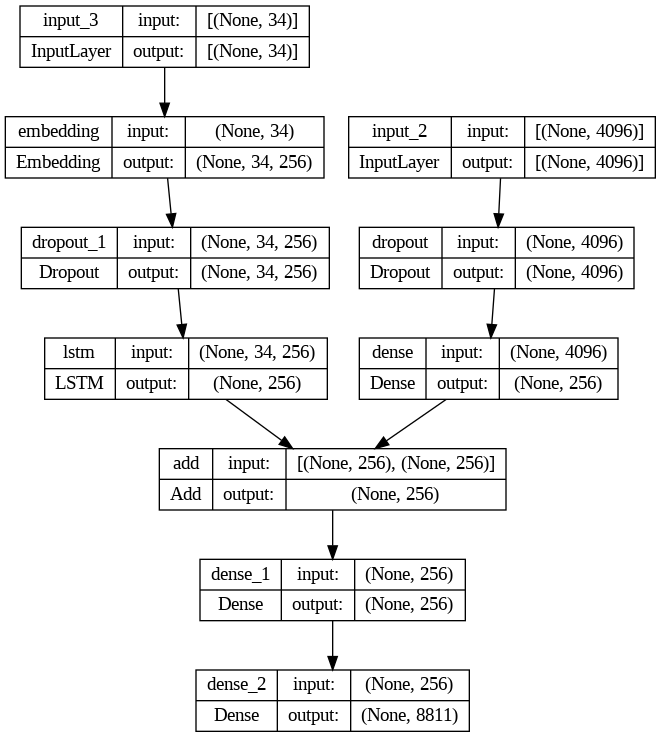

In [ ]:
#Model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
batch_size = 100
steps = len(train) // batch_size
print(steps)

60


In [ ]:
#!rm -rf /content/drive/MyDrive/datasets/Flicker8k_Dataset/2258277193_586949ec62.jpg
#!rm -rf /content/drive/MyDrive/datasets/Flicker8k_Dataset/3308171165_20f93d2fba.jpg

In [ ]:
del mapping['2258277193_586949ec62']
del mapping['3308171165_20f93d2fba']

In [ ]:
#Train Model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

189/189 [==============================] - 58s 309ms/step - loss: 2.1554


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')